In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.inspection import partial_dependence
from IncrementsRegression import model

In [3]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
BASEPATH = 'C:\SuryaMain\Python Projects\ChinookUL\ChinookGrowthProject'
SIMULATION_BASEPATH = os.path.join(BASEPATH, "simulate_nonlinear_data")

In [60]:
class RFRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, params = None):
        self.hparams = params
        self.model = RandomForestRegressor(**self.hparams)
        self.rsquared = None
        self.istrained = False
        self.feature_importances_ = None

    def fit(self, X_train, y_train):
        self.model.fit(X_train,y_train)
        self.rsquared = self.model.score(X_train,y_train)
        self.istrained = True
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X, y=None):
        pred = self.model.predict(X)
        if y is not None:
            self.rsquared = r2_score(y, pred)
        return pred
    
    def get_rsquared(self):
        return self.rsquared;
    
    def get_istrained(self):
        return self.istrained;

In [135]:
def train_sim_model(params = {"n_estimators": 20, "oob_score":True, "min_impurity_decrease":0.1}, data_path = os.path.join(SIMULATION_BASEPATH, 'data_set_1')):
    X = pd.read_csv(os.path.join(data_path, 'X.csv')).drop(['Unnamed: 0'], axis=1)
    y = pd.read_csv(os.path.join(data_path, 'y.csv')).drop(['Unnamed: 0'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=12)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    rf_model = RFRegressor(params = params)
    rf_model.fit(X_train,y_train.ravel())
    r2_train = rf_model.rsquared
    test_pred = rf_model.predict(X_test, y_test)
    r2_test = rf_model.get_rsquared()
    return [rf_model, (r2_train, r2_test)]

def sim_dataframe(simulation_datapath = SIMULATION_BASEPATH):
    features = []
    r2_train_vals = []
    r2_test_vals = []
    total_effects = []
    nonlinear_vals = []
    interactions_vals = []
    rhoX_vals = []
    intX_vals = []
    rhoU_vals = []
    intU_vals = []
    n = []
    cos_sims = []
    correlations = []

    for data_path in os.listdir(simulation_datapath):
        if "data_set_" in data_path:
            full_datapath = os.path.join(SIMULATION_BASEPATH,data_path)
            rf_model, (r2_train, r2_test) = train_sim_model(data_path = full_datapath)
            cos_sim, correlation = compare_vi(rf_model, full_datapath)
            
            hyperparams = pd.read_csv(os.path.join(full_datapath, 'hyper_params.csv'))
            features.append(hyperparams['m'][0])
            r2_train_vals.append(r2_train)
            r2_test_vals.append(r2_test)
            total_effects.append(hyperparams['total_effect'][0])
            nonlinear_vals.append(hyperparams['nonlinear'][0])
            interactions_vals.append(hyperparams['interactions'][0])
            rhoX_vals.append(hyperparams['rho_X'][0])
            intX_vals.append(hyperparams['int_X'][0])
            rhoU_vals.append(hyperparams['rho_U'][0])
            intU_vals.append(hyperparams['int_U'][0])
            n.append(hyperparams['n'][0])
            cos_sims.append(cos_sim)
            correlations.append(correlation)

    df = pd.DataFrame({
        'features': features,
        'r2_train': r2_train_vals,
        'r2_test': r2_test_vals,
        'totals_effect': total_effects,
        'nonlinear': nonlinear_vals,
        'interactions': interactions_vals,
        'rho_X': rhoX_vals,
        'int_X': intX_vals,
        'rho_U': rhoU_vals,
        'int_U': intU_vals,
        'N': n,
        'cos_sim': cos_sims,
        'correlation':correlations

    })

    return df

def compare_vi(model, path):
    imp = np.array(pd.read_csv(os.path.join(path, 'Imp.csv'))['Imp'])
    imp_rf = model.feature_importances_
    cos_sim = np.inner(imp, imp_rf) / (np.linalg.norm(imp_rf) * np.linalg.norm(imp))
    correlation = np.corrcoef(imp, imp_rf)[0][1]
    print(correlation)
    
    return [cos_sim, correlation]

    

In [136]:
data_1_df = sim_dataframe()

1.0
0.5400285069453219
0.9526043641601375
0.7917539815469925
-0.154441979528352
0.20590327173564238
0.23907643629458233
-0.38134946705012546
0.9468464063759531
0.5813681582017983
-0.2651538696908749
0.48455597276306966
0.7596203261269803
-0.9999999999999999
0.7735385241872229
0.6070670251558984
0.7575092276410286
-0.683475119501292
0.1934819160634057
-0.28114186181578293
-0.9999999999999999
0.10311118644758259
0.6221600341810347
0.07154334224882256
0.9999999999999998
1.0
0.36329605132785225
-0.2560130224154797
0.6848323787201613
0.920314076771541
-0.00798039178728409
-1.0
0.871817429976787
-0.10210246939849497
-0.19465906005362274
0.31859899792349505
-0.2890032490665321
0.038744694363908
0.5304256257462638
-1.0
1.0
0.37146443908100624
1.0
-0.4116949769137686
-0.4055713740882179
-0.08792565873026245
-0.6239210349317708
-0.31548301255047556
0.8417360230252672
0.3352214961390116
0.38746384703610104
-0.447194913317108
-0.09425682513870469
0.21436617505020952
0.49737957221452495
0.254476822

c:\python\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


-0.16710492884088315
-0.6977951531948537
-0.033372624616466
-0.2653861769148349
1.0
-1.0
0.6182135394620425
0.9728019338529629
0.7578567134676195
0.9428950693337834
-0.14103218096131662
0.3696928899714286
0.7744750816007354
1.0
0.07976355054237759
-0.026396944679126337
-0.09326696210147269
-0.25851526603234115
0.7450114274771653
0.1728240754011018
0.9973770240280482
0.8095104061891824
0.9584572775146103
0.9401356541757279


In [137]:
data_1_df

,features,r2_train,r2_test,totals_effect,nonlinear,interactions,rho_X,int_X,rho_U,int_U,N,cos_sim,correlation
0,2,0.853356,0.570636,0.75,1,0,0.5,1,0.5,2,30,0.983886,1.000000
1,5,0.757732,0.185125,0.75,1,2,0.0,1,0.0,2,30,0.809033,0.540029
2,10,0.726835,0.271919,0.75,0,0,0.0,1,0.5,2,50,0.974496,0.952604
3,5,0.773651,-0.935265,0.75,0,2,0.5,1,0.5,2,30,0.859007,0.791754
4,10,0.859785,0.493936,0.75,0,2,0.5,1,0.5,2,30,0.167593,-0.154442
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10,0.853957,-2.171198,0.75,0,0,0.5,1,0.0,2,30,0.380494,0.172824
96,5,0.482516,0.149152,0.50,1,0,0.0,1,0.0,2,100,0.990354,0.997377
97,10,0.818938,0.879357,0.75,1,1,0.5,1,0.5,2,30,0.792875,0.809510
98,5,0.757863,0.261597,0.75,0,2,0.5,1,0.5,2,50,0.959139,0.958457


# R Squared Boxplots

In [111]:
def fig_boxplot_r2differences(df, xvar, title='', show_outliers=False):
    r2_differences_all = {}
    stats_all = {}
    for val in df[xvar].unique():
        r2_differences = np.array(df.loc[df[xvar] == val]['r2_train'] - df.loc[df[xvar] == val]['r2_test'])
        q1 = np.quantile(r2_differences, 0.25)
        q3 = np.quantile(r2_differences, 0.75)
        med = np.median(r2_differences)
        upper_bound = q3 + (1.5*(q3-q1))
        lower_bound = q1 - (1.5*(q3-q1))

        r2_differences_all[f'{xvar}_{str(val)}'] = r2_differences
        outliers = sorted(r2_differences[(r2_differences <= lower_bound) | (upper_bound <= r2_differences)])
        stats_all[f'{xvar}_{str(val)}'] = {'outliers': outliers, 'median':med, 'IQR':q3-q1}

    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    plt.boxplot(r2_differences_all.values(), showfliers=show_outliers)
    k = len(df[xvar].unique())
    plt.xticks([i for i in range(1,k+1)],sorted(list(df[xvar].unique())))
    plt.grid()

    plt.xlabel(title)
    plt.ylabel("Train r^2 - Test r^2 (Decimal 0.0-1.0)")
    
    return [fig, stats_all]


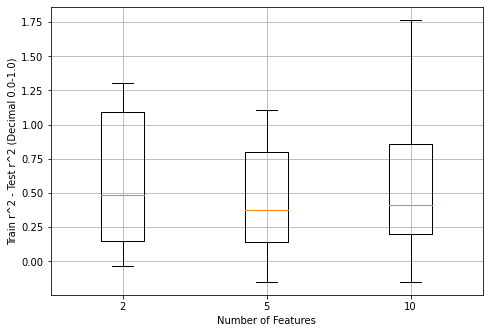

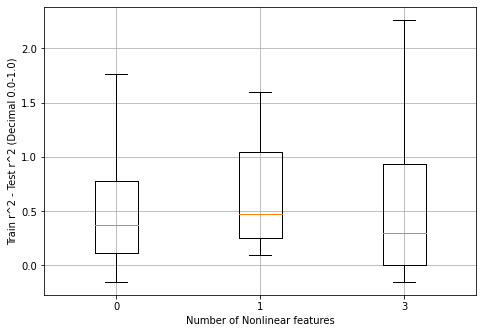

In [112]:
fig_bxplt_features, stats_features= fig_boxplot_r2differences(data_1_df, 'features', title='Number of Features')
fig_bxplt_nonlinear, stats_nonlinear = fig_boxplot_r2differences(data_1_df, 'nonlinear', title='Number of Nonlinear features')

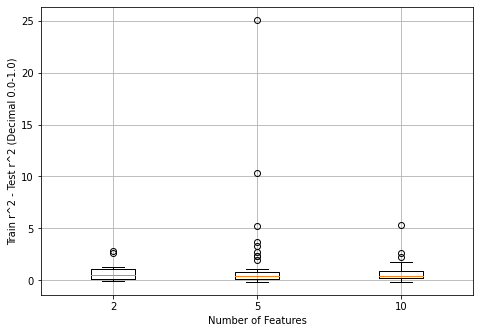

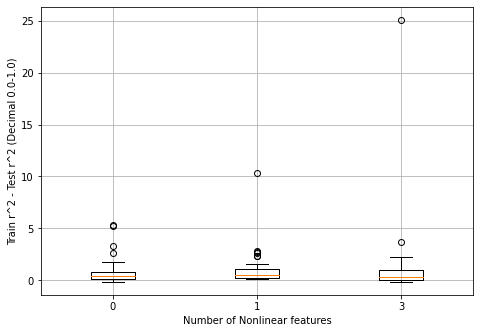

In [113]:
fig_bxplt_features, stats_features= fig_boxplot_r2differences(data_1_df, 'features', title='Number of Features', show_outliers=True)
fig_bxplt_nonlinear, stats_nonlinear = fig_boxplot_r2differences(data_1_df, 'nonlinear', title='Number of Nonlinear features', show_outliers=True)

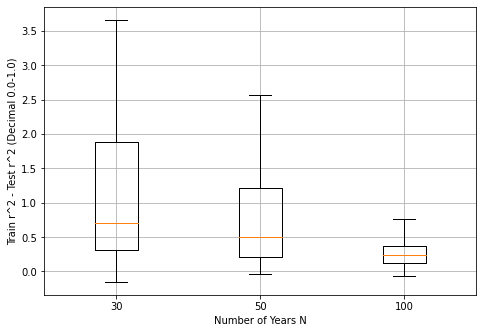

In [114]:
fig_bxplt_n, stats_n = fig_boxplot_r2differences(data_1_df, 'N', title='Number of Years N', show_outliers=False)

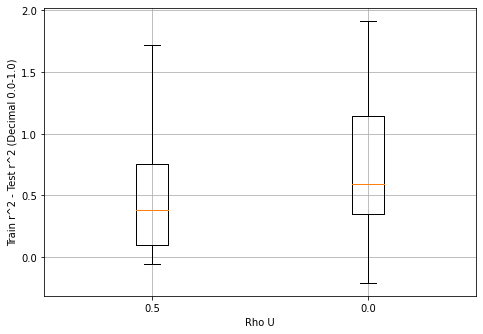

In [68]:
fig_bxplt_n, stats_n = fig_boxplot_r2differences(data_1_df, 'rho_U', title='Rho U', show_outliers=False)

In [115]:
def fig_boxplot_totaleffect(df, xvar, title='', show_outliers=False):
    differences_all = {}
    stats_all = {}
    for val in df[xvar].unique():
        differences = np.array(df.loc[df[xvar] == val]['r2_train'] - df.loc[df[xvar] == val]['totals_effect'])
        q1 = np.quantile(differences, 0.25)
        q3 = np.quantile(differences, 0.75)
        med = np.median(differences)
        upper_bound = q3 + (1.5*(q3-q1))
        lower_bound = q1 - (1.5*(q3-q1))

        differences_all[f'{xvar}_{str(val)}'] = differences
        outliers = sorted(differences[(differences <= lower_bound) | (upper_bound <= differences)])
        stats_all[f'{xvar}_{str(val)}'] = {'outliers': outliers, 'median':med, 'IQR':q3-q1}

    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    plt.boxplot(differences_all.values(), showfliers=show_outliers)
    k = len(df[xvar].unique())
    plt.xticks([i for i in range(1,k+1)],np.array(df[xvar].unique(), dtype=str))
    plt.grid()

    plt.xlabel(title)
    plt.ylabel("Train r^2 - Total Effect (Decimal 0.0-1.0)")
    
    return [fig, stats_all]



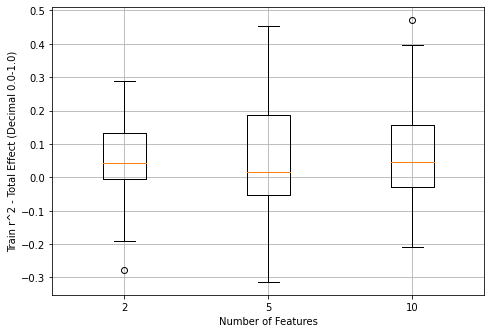

In [116]:
fig_bxplt_totaleffect, stats_totaleffect= fig_boxplot_totaleffect(data_1_df, 'features', title='Number of Features', show_outliers=True)

In [20]:
# Test: saving matplotlib plots in pdfs
def fig_barh(ylabels, xvalues, title=''):
    # create a new figure
    fig = plt.figure()

    # plot to it
    yvalues = 0.1 + np.arange(len(ylabels))
    plt.barh(yvalues, xvalues, figure=fig)
    yvalues += 0.4
    plt.yticks(yvalues, ylabels, figure=fig)
    if title:
        plt.title(title, figure=fig)

    # return it
    return fig

def write_pdf(fname, figures):
    path = os.path.join(BASEPATH, 'main')
    doc = PdfPages(os.path.join(path, fname))
    for fig in figures:
        fig.savefig(doc, format='pdf')
    doc.close()

a = fig_barh(['a','b','c'], [1, 2, 3], 'Test #1')
b = fig_barh(['x','y','z'], [5, 3, 1], 'Test #2')
write_pdf('test.pdf', [a, b])

# Variable Importance

In [138]:
def fig_boxplot_vi(df, show_outliers=False): #  boxplot for 
    vals1 = np.array(df['cos_sim'])
    q1 = np.quantile(vals1, 0.25)
    q3 = np.quantile(vals1, 0.75)
    med = np.median(vals1)
    upper_bound = q3 + (1.5*(q3-q1))
    lower_bound = q1 - (1.5*(q3-q1))

    outliers = sorted(vals1[(vals1 <= lower_bound) | (upper_bound <= vals1)])
    stats1 = {'outliers': outliers, 'median':med, 'IQR':q3-q1}

    vals2 = np.array(df['correlation'])
    q1 = np.quantile(vals2, 0.25)
    q3 = np.quantile(vals2, 0.75)
    med = np.median(vals2)
    upper_bound = q3 + (1.5*(q3-q1))
    lower_bound = q1 - (1.5*(q3-q1))

    outliers = sorted(vals2[(vals2 <= lower_bound) | (upper_bound <= vals2)])
    stats2 = {'outliers': outliers, 'median':med, 'IQR':q3-q1}
    
    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    plt.boxplot([vals1, vals2], showfliers=show_outliers)
    plt.grid()
    plt.xticks([1,2], ["cos_sim", "correlation"])
    plt.ylabel("Variable Imp. Measurement (-1.0 to 1.0)")
    
    return [fig, {"cos_sim": stats1, "correlation":stats2}]


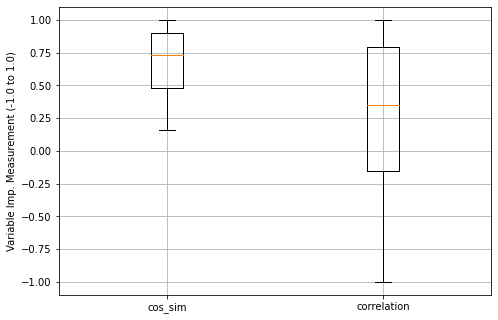

In [139]:
fig_bxplt_vi, stats_vi= fig_boxplot_vi(data_1_df, show_outliers=True)

In [140]:
data_1_df.to_csv('sim_results3.csv')